In [1]:
import os
import numpy as np
from starred.deconvolution.deconvolution import load_Deconv_model
import json 

from starred.deconvolution.loss import Prior, Loss
from starred.deconvolution.parameters import ParametersDeconv
from starred.optim.optimization import Optimizer
from starred.optim.sampling import Sampler
from starred.optim.inference_base import FisherCovariance
from starred.plots.plot_function import plot_deconvolution, plot_loss, view_deconv_model,  plot_convergence_by_walker
from starred.utils.generic_utils import convert_list_to_numpy_array
from starred.utils.noise_utils import propagate_noise
from copy import deepcopy

import corner 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [2]:

#Path definition 
M = 1 # point sources 
sim_input_name = 'mock_SNIa_exptime30'
folder = './output/test_SNIa' 
instrument = 'WFI-time-series-2M1134'
subsampling_factor = 2 
theta_E = 0.5
n_images = 100

sim_folder = os.path.join(folder, sim_input_name, instrument)
outpath = os.path.join(sim_folder, 'output_lambda%2.2f-%2.2f_pos100_upsample%i'%(1.0, 1.0, subsampling_factor), 'theta_E_%2.2f'%theta_E)
model_path = os.path.join(outpath, 'model.hdf5')


# Load the optimized model

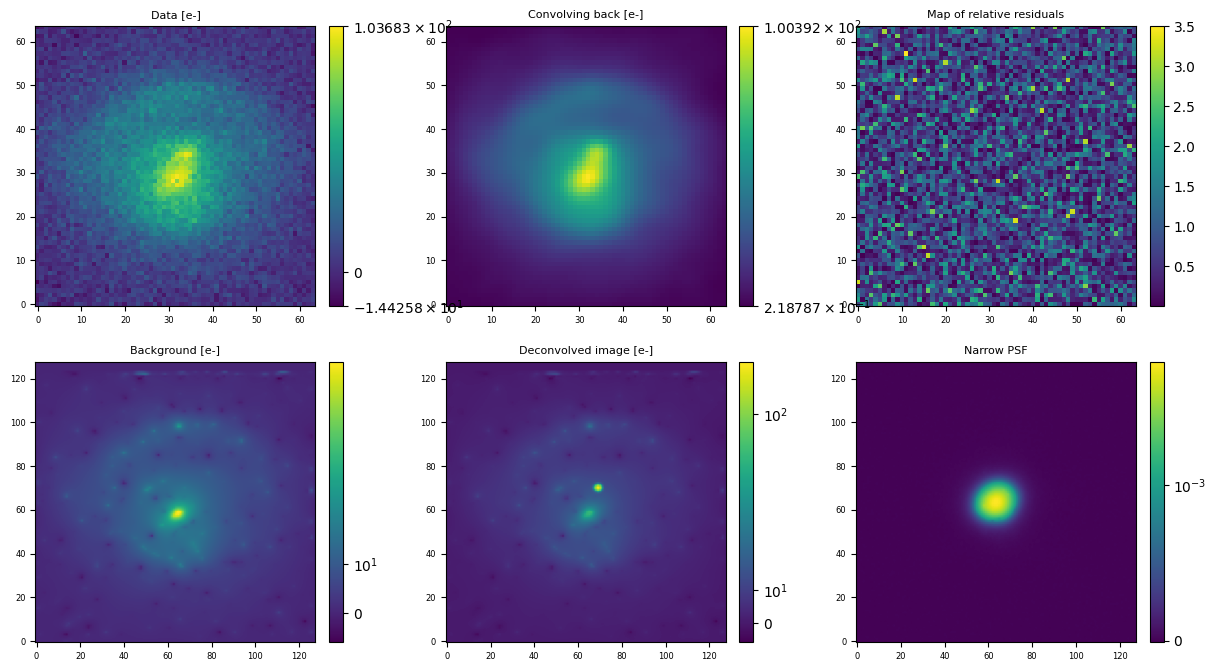

In [3]:
model, kwargs, data, sigma_2 = load_Deconv_model(model_path)
with open(os.path.join(outpath, 'sigmas_amps.json'), 'r') as f:   
    sigmas_dic = json.load(f)

with open(os.path.join(outpath, 'info_dic.json'), 'r') as f: 
    info_dic = json.load(f)

with open(os.path.join(outpath, 'kwargs_fixed.json'), 'r') as f: 
    kwargs_fixed = convert_list_to_numpy_array(json.load(f))

with open(os.path.join(outpath, 'kwargs_up.json'), 'r') as f: 
    kwargs_up = convert_list_to_numpy_array(json.load(f))

with open(os.path.join(outpath, 'kwargs_down.json'), 'r') as f: 
    kwargs_down = convert_list_to_numpy_array(json.load(f))

parameters = ParametersDeconv(kwargs, 
                              kwargs_fixed, 
                              kwargs_up=kwargs_up, 
                              kwargs_down=kwargs_down)

#We recompute the W matrix, as it was not saved. 
W = propagate_noise(model, np.sqrt(sigma_2), kwargs, wavelet_type_list=['starlet'],
                        method='MC',
                        num_samples=500, seed=1, likelihood_type='chi2', verbose=False,
                        upsampling_factor=subsampling_factor)[0]

#review the model
fig = plot_deconvolution(model, data, sigma_2, model.psf, kwargs, epoch = 75, units='e-')

In [4]:
print(sigmas_dic)
print(info_dic)

{'PSFshotnoiseWPFC': [[39.7775764465332], [39.78147888183594], [43.4848518371582], [43.48318862915039], [32.13096618652344], [32.12996292114258], [50.01408386230469], [50.01719284057617], [31.934310913085938], [31.92832374572754], [34.362892150878906], [34.36118698120117], [32.16607666015625], [32.16480255126953], [30.90758514404297], [30.908103942871094], [53.20707321166992], [53.207000732421875], [47.875179290771484], [47.8682975769043], [33.926082611083984], [33.925743103027344], [47.582725524902344], [47.58139419555664], [27.326093673706055], [27.323959350585938], [39.8245849609375], [39.83534622192383], [36.383644104003906], [36.38547897338867], [22.47492790222168], [22.47085189819336], [30.285024642944336], [30.287065505981445], [24.678232192993164], [24.677207946777344], [33.16748809814453], [33.16310501098633], [29.616512298583984], [29.61406898498535], [39.0179328918457], [39.01643371582031], [25.8010311126709], [25.797988891601562], [42.66172409057617], [42.671165466308594], 

# Estimating errors: from the covariance Matrix

We will reduce the dimensianility of the problem before computing the covariance matrix. We are fixing the background and ignore covariances between the point source and the background to avoid using to much memory. 

We rerun the fit once, to ensure that we are still at the minimum when some of the parameters are fixed.

In [5]:
def get_args_errs(kwargs, kwargs_fixed, kwargs_up, kwargs_down, data, sigma_2, model, parameters, diagonal_only):        
    parameters = ParametersDeconv(kwargs_init=kwargs, 
                                  kwargs_fixed=kwargs_fixed, 
                                  kwargs_up=kwargs_up, 
                                  kwargs_down=kwargs_down)
    
    args = parameters.kwargs2args(kwargs)
    print(f"Reoptimising {len(args)} parameters.")

    loss = Loss(data, model, parameters, sigma_2, W=W, 
                regularization_terms='l1_starlet', 
                regularization_strength_hf=1., regularization_strength_scales=1.)
    kwargs_optax_fast = {
        'max_iterations': 60, 'min_iterations': None,
        'init_learning_rate': 5e-3, 'schedule_learning_rate': True,
        'restart_from_init': True, 'stop_at_loss_increase': False,
        'progress_bar': True, 'return_param_history': True
    }
    optim = Optimizer(loss, parameters, method='adabelief')
    best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(**kwargs_optax_fast)

    print('LogL:', logL_best_fit)

    kwargs_refit = parameters.args2kwargs(best_fit)

    fish = FisherCovariance(parameters, optim, diagonal_only)
    fish.compute_fisher_information()
    k_errs = fish.get_kwargs_sigma()
    free_param = parameters.get_all_free_param_names(kwargs)
    samples = fish.draw_samples(num_samples=5000)
    return k_errs, samples, free_param, kwargs_refit, extra_fields

# we fixed all the parameters, except a_i, cx and cy, the amplitude of the SNIa after explosion and its position. 
# This reduces to 38 amplitudes and 2 centroids parameters. 
kwargs_fixed['kwargs_analytic']['dx']= kwargs['kwargs_analytic']['dx'].copy()
kwargs_fixed['kwargs_analytic']['dy']= kwargs['kwargs_analytic']['dy'].copy()
kwargs_fixed['kwargs_background']['h'] = kwargs['kwargs_background']['h'].copy()
kwargs_fixed['kwargs_background']['mean'] = kwargs['kwargs_background']['mean'].copy()
    
k_errs, samples_fisher, free_param_fisher, kwargs_refit, extra_fields = get_args_errs(kwargs, kwargs_fixed, kwargs_up, kwargs_down, data, sigma_2, model, parameters, diagonal_only=False)
starred_err = k_errs['kwargs_analytic']['a'].reshape(n_images, M) * info_dic['Norm'] * model.scale
sigmas_dic['STARRED'] = starred_err.tolist()

Reoptimising 40 parameters.


optax.adabelief: 100%|██████████| 60/60 [00:27<00:00,  2.22it/s]


LogL: 236558.69


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [40.08589553833008], [40.10032272338867], [40.161869049072266], [40.00175857543945], [36.81631851196289], [36.72333908081055], [36.170936584472656], [36.305782318115234], [47.02372360229492], [47.10029220581055], [34.002784729003906], [34.16069030761719], [43.2772331237793], [43.12793731689453], [32.880516052246094], [33.059913635253906], [28.652223587036133], [28.400911331176758], [30.490520477294922], [30.568931579589844], [38.41020584106445], [38.52895736694336], [33.72849655151367], [33.677101135253906], [30.478635787963867], [30.487489700317383], [36.846

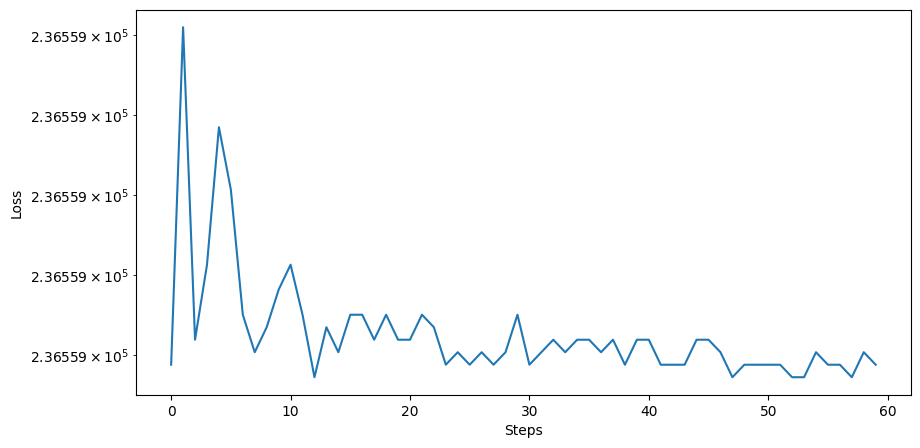

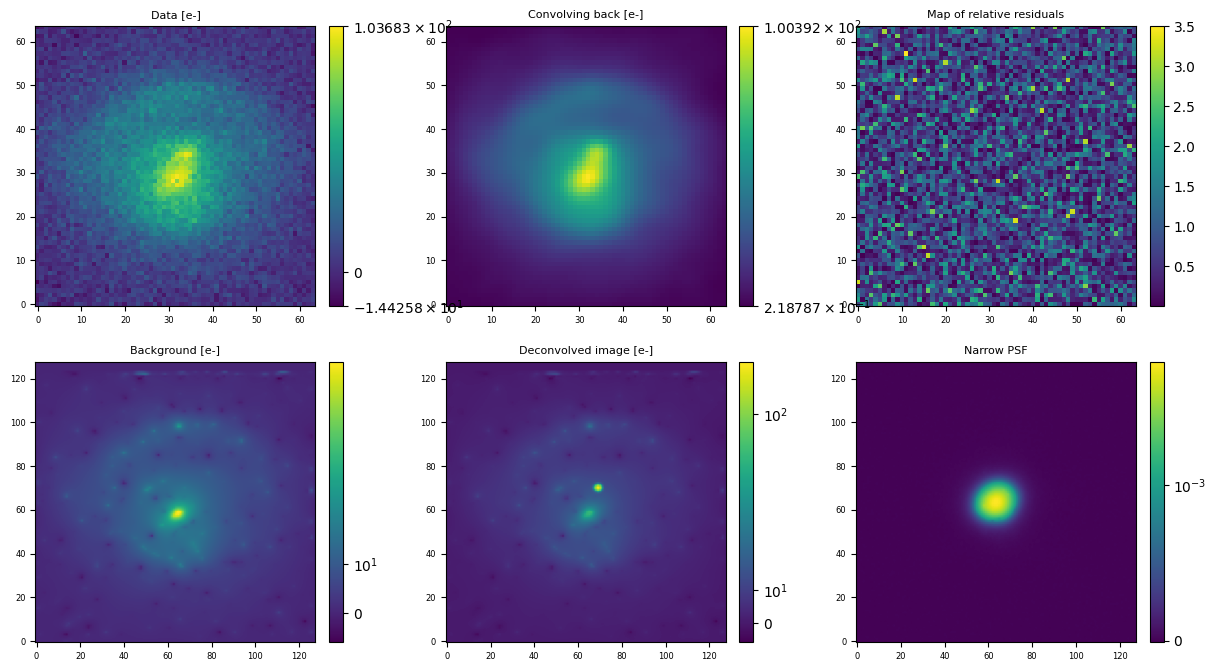

In [6]:
#check the convergence of the model with the fixed parameters, it should be very quick 
fig2 = plot_loss(extra_fields['loss_history'])
fig = plot_deconvolution(model, data, sigma_2, model.psf, kwargs, epoch = 75, units='e-')

print(sigmas_dic['STARRED'])
print(sigmas_dic['PSFshotnoiseWPFC'])

# Removing position covariances: 

They is only a very small covariance between the point source position and the amplitudes. 

In [7]:
#reload the model:
kwargs_fixed['kwargs_analytic']['c_x']= kwargs['kwargs_analytic']['c_x'].copy()
kwargs_fixed['kwargs_analytic']['c_y']= kwargs['kwargs_analytic']['c_y'].copy()
    
k_errs3, samples_fishe3r, free_param_fisher3, kwargs_refit3, extra_fields3 = get_args_errs(kwargs, kwargs_fixed, kwargs_up, kwargs_down, data, sigma_2, model, parameters, diagonal_only=False)
starred_err3 = k_errs3['kwargs_analytic']['a'].reshape(n_images, M) * info_dic['Norm'] * model.scale

print(starred_err3.tolist())
print(starred_err.tolist())

Reoptimising 38 parameters.


optax.adabelief: 100%|██████████| 60/60 [00:25<00:00,  2.34it/s]


LogL: 236558.7
[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [40.08552551269531], [40.10026168823242], [40.16173553466797], [40.00172424316406], [36.816246032714844], [36.72311019897461], [36.170814514160156], [36.3049430847168], [47.023216247558594], [47.1002311706543], [34.002197265625], [34.160552978515625], [43.27698516845703], [43.127899169921875], [32.88010787963867], [33.05972671508789], [28.651134490966797], [28.400562286376953], [30.490406036376953], [30.568788528442383], [38.409690856933594], [38.52873229980469], [33.727848052978516], [33.677032470703125], [30.477476119995117], [30.486446380615

# EMCEE Sampling:

This takes about an 1h on a CPU with emcee, it should be faster on GPU but I haven't tested it. Using HMC should also speedup things but this is not fully tested. 

In [8]:
#unfix source position, delete the key in the dictionnary
del kwargs_fixed['kwargs_analytic']['c_x']
del kwargs_fixed['kwargs_analytic']['c_y']

In [9]:
def sampleMCMC(kwargs, kwargs_fixed, kwargs_up, kwargs_down, data, sigma_2, model, parameters, sampler = 'mchmc'):        
    parameters = ParametersDeconv(kwargs_init=kwargs, 
                                  kwargs_fixed=kwargs_fixed, 
                                  kwargs_up=kwargs_up, 
                                  kwargs_down=kwargs_down)
    
    args = parameters.kwargs2args(kwargs)
    print(f"Sampling {len(args)} free parameters.")

    loss = Loss(data, model, parameters, sigma_2, W=W,
                regularization_terms='l1_starlet', 
                regularization_strength_hf=1., regularization_strength_scales=1.)

    samp = Sampler(loss, parameters, sampler=sampler)
    if sampler == 'mchmc': 
        kwargs_sampler = {'num_steps':10, 'num_chains':50, 'sigma_init':1e-1}#takes a while on CPU, to be tested on GPU
    elif sampler == 'emcee': 
        kwargs_sampler = {'walker_ratio':10, 'nsteps':100, 'sigma_init':1e-1}

    if os.path.exists(os.path.join(outpath, 'samples.txt')): 
        print('I am not resampling, I have found the chain.')
        samples = np.loadtxt(os.path.join(outpath, 'samples.txt'))
        logl, runtime = None, None
    else: 
        samples, logl, runtime = samp.sample(args, **kwargs_sampler)
        
    free_param = parameters.get_all_free_param_names(kwargs)

    return samples, logl, runtime, free_param, kwargs_sampler

In [10]:
samples, logl, runtime, free_param, kwargs_sampler = sampleMCMC(kwargs, kwargs_fixed, kwargs_up, kwargs_down, data, sigma_2, model, parameters, sampler = 'emcee')

Sampling 40 free parameters.


100%|██████████| 100/100 [1:41:19<00:00, 60.80s/it]


In [11]:
print(np.shape(samples))
if not os.path.exists(os.path.join(outpath, 'samples.txt')): 
    np.savetxt(os.path.join(outpath, 'samples.txt'), samples)

#check the convergence of the chain: 
fig_walkers = plot_convergence_by_walker(samples, free_param, kwargs_sampler['walker_ratio']*len(free_param), verbose = True)

(40000, 40)
a_62 4.4201 +/- 0.1260
a_63 4.6270 +/- 0.1158
a_64 10.6992 +/- 0.1932
a_65 10.6319 +/- 0.1909
a_66 14.5689 +/- 0.1927
a_67 14.6419 +/- 0.1971
a_68 13.7266 +/- 0.1843
a_69 13.6385 +/- 0.1812
a_70 9.5686 +/- 0.1932
a_71 9.7424 +/- 0.2065
a_72 5.4830 +/- 0.1443
a_73 5.5711 +/- 0.1334
a_74 3.0962 +/- 0.0942
a_75 3.2703 +/- 0.1000
a_76 1.9377 +/- 0.0606
a_77 2.0810 +/- 0.0682
a_78 1.6169 +/- 0.0533
a_79 1.5976 +/- 0.0515
a_80 2.0705 +/- 0.0569
a_81 1.9220 +/- 0.0685
a_82 2.0009 +/- 0.0599
a_83 2.1344 +/- 0.0632
a_84 2.0596 +/- 0.0599
a_85 2.0906 +/- 0.0684
a_86 2.1099 +/- 0.0636
a_87 2.1198 +/- 0.0638
a_88 2.1208 +/- 0.0657
a_89 2.2251 +/- 0.0609
a_90 2.0968 +/- 0.0655
a_91 2.0743 +/- 0.0606
a_92 2.0874 +/- 0.0599
a_93 2.1485 +/- 0.0611
a_94 2.1258 +/- 0.0629
a_95 2.0376 +/- 0.0604
a_96 2.1014 +/- 0.0689
a_97 1.9487 +/- 0.0613
a_98 2.1634 +/- 0.0711
a_99 2.1358 +/- 0.0702
c_x 2.6405 +/- 0.0129
c_y 5.0420 +/- 0.0125


In [12]:
#compare the posteriors from Hessian matrix and from the MCMC: 
#remove the first part of the chain keep only the last 1000 samples
samples_red = samples[35000:,:]

err_emcee = np.std(samples_red[:, :-2], axis=0) * model.scale * info_dic['Norm'] #There is a scaling for the point sources "model.scale" and an overall scaling of the images storred in info_dic['Norm']
err_emcee_list = [] 
for i in range(100): 
    if i < 62: 
        err_emcee_list.append([0.])
    else: 
        err_emcee_list.append([err_emcee[i-62]])

print(starred_err.tolist())
print(err_emcee_list)

print(len(err_emcee_list))
sigmas_dic['EMCEE'] = err_emcee_list

print(np.shape(samples_fisher))
print(np.shape(samples_red))


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [40.08589553833008], [40.10032272338867], [40.161869049072266], [40.00175857543945], [36.81631851196289], [36.72333908081055], [36.170936584472656], [36.305782318115234], [47.02372360229492], [47.10029220581055], [34.002784729003906], [34.16069030761719], [43.2772331237793], [43.12793731689453], [32.880516052246094], [33.059913635253906], [28.652223587036133], [28.400911331176758], [30.490520477294922], [30.568931579589844], [38.41020584106445], [38.52895736694336], [33.72849655151367], [33.677101135253906], [30.478635787963867], [30.487489700317383], [36.846

/var/folders/k5/9nxb2fnj4zsbb1nrtpvbf8000000gn/T/ipykernel_65610/2224556803.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('gist_rainbow', n)


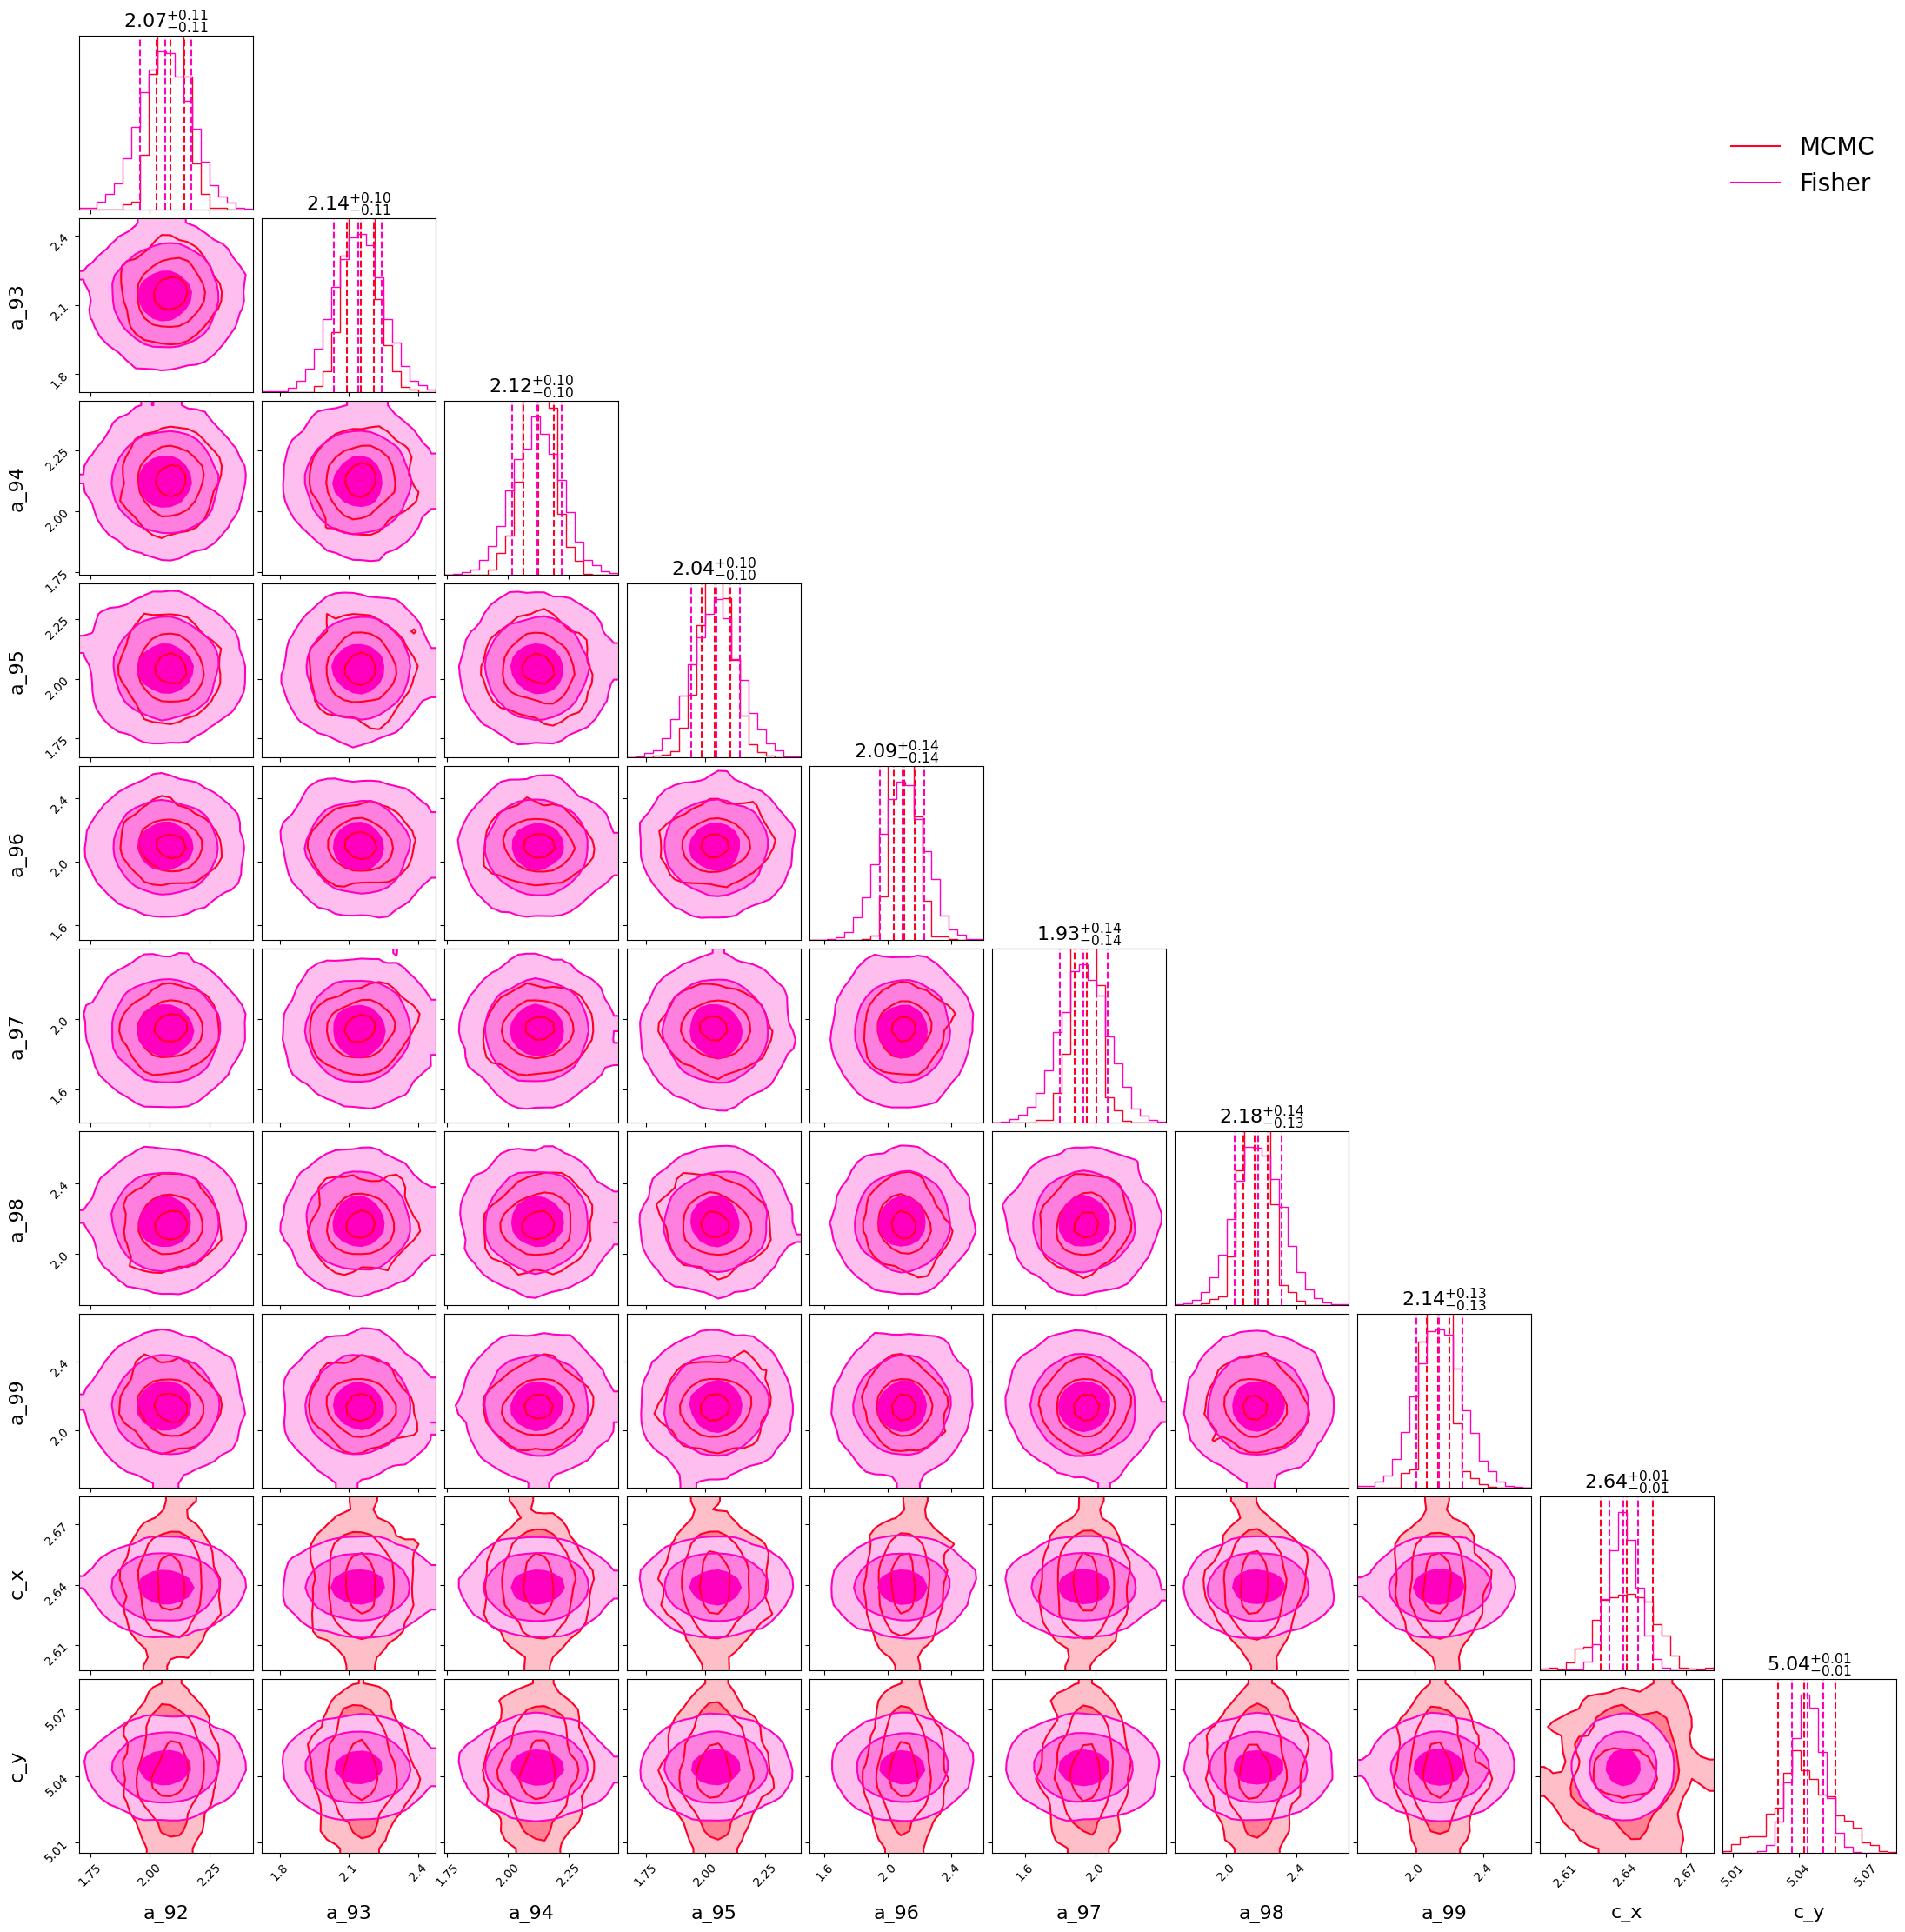

In [13]:
CORNER_KWARGS = dict(
    smooth=0.9,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    quantiles=[0.16, 0.5,  0.84],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=False,
    plot_datapoints=False,
    fill_contours=True,
    show_titles=True,
    max_n_ticks=3,
)
def overlaid_corner(samples_list, sample_labels, labels):
    """Plots multiple corners on top of each other"""
    # get some constants
    n = len(samples_list)
    _, ndim = samples_list[0].shape
    max_len = max([len(s) for s in samples_list])
    cmap = plt.cm.get_cmap('gist_rainbow', n)
    colors = [cmap(i) for i in range(n)]

    plot_range = []
    for dim in range(ndim):
        plot_range.append(
            [
                min([min(samples_list[i].T[dim]) for i in range(n)]),
                max([max(samples_list[i].T[dim]) for i in range(n)]),
            ]
        )

    CORNER_KWARGS.update(range=plot_range)

    fig = corner.corner(
        samples_list[0],
        color=colors[0],
        labels=labels, 
        **CORNER_KWARGS
    )

    for idx in range(1, n):
        fig = corner.corner(
            samples_list[idx],
            fig=fig,
            weights=get_normalisation_weight(len(samples_list[idx]), max_len),
            color=colors[idx],
            **CORNER_KWARGS
        )

    plt.legend(
        handles=[
            mlines.Line2D([], [], color=colors[i], label=sample_labels[i])
            for i in range(n)
        ],
        fontsize=20, frameon=False,
        bbox_to_anchor=(1, ndim), loc="upper right"
    )
    return fig


def get_normalisation_weight(len_current_samples, len_of_longest_samples):
    return np.ones(len_current_samples) * (len_of_longest_samples / len_current_samples)

#we plot only a subset of the parameters, other wise the figure is too big!
param_to_plot = 10
fig = overlaid_corner([samples_red[:, -param_to_plot:], samples_fisher[:, -param_to_plot:]], ['MCMC', 'Fisher'], free_param[-param_to_plot:])

Seems that emcee sampling leads to slightly smaller errors. I don't know if this is due to the chain that might not be fully converged.

# Include covariances with the extended source

We will compute the background covariances, but only for a the 5*5 grid of (sub-)pixel under the point sources, to limit the number of free parameters. 

In [14]:
#given the position of the point source, we recover a mask containing the pixel that are potentially correlated with the point source amplitude
nan_mask = model.get_mask_pts_source(kwargs, mask_size=5, nan_mask=True) 
nan_mask = np.ravel(nan_mask) # put the maks in 1D to match the dimension of the background array

kwargs_fixed['kwargs_background']['h'] = nan_mask * kwargs['kwargs_background']['h'].copy() #put nan only at the position of the mask, all other pixels are fixed. Nan = not fixed, they will be sampled

#recompute the covariance matrix, alternatively, you could resample the posteriors in an MCMC. 
k_errs_mask, samples_fisher_mask, free_param_fisher_mask, kwargs_refit_mask, extra_fields_mask = get_args_errs(kwargs, kwargs_fixed, kwargs_up, kwargs_down, data, sigma_2, model, parameters, diagonal_only=False)
starred_err_mask = k_errs_mask['kwargs_analytic']['a'].reshape(n_images, M) * info_dic['Norm'] * model.scale

print(sigmas_dic['STARRED'])
print(starred_err_mask.tolist())

Reoptimising 65 parameters.


optax.adabelief: 100%|██████████| 60/60 [00:24<00:00,  2.41it/s]


LogL: 236558.69
[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [40.08589553833008], [40.10032272338867], [40.161869049072266], [40.00175857543945], [36.81631851196289], [36.72333908081055], [36.170936584472656], [36.305782318115234], [47.02372360229492], [47.10029220581055], [34.002784729003906], [34.16069030761719], [43.2772331237793], [43.12793731689453], [32.880516052246094], [33.059913635253906], [28.652223587036133], [28.400911331176758], [30.490520477294922], [30.568931579589844], [38.41020584106445], [38.52895736694336], [33.72849655151367], [33.677101135253906], [30.478635787963867], [30.487489700

/Users/martin/Desktop/modules/starred/starred/optim/inference_base.py:140: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(self._param.best_fit_values(), self.covariance_matrix, size=num_samples)


As expected, the error bars have slightly increased due to the additional covariances with the background pixels. This is a small effect since the background is very well constrained from the epochs where there is no point source.

In [15]:
fig = overlaid_corner([samples_fisher_mask[:, 35:45]], ['Fisher background covariances'], free_param_fisher_mask[35:45])

print(free_param)
print(free_param_fisher) 
print(free_param_fisher_mask)

/var/folders/k5/9nxb2fnj4zsbb1nrtpvbf8000000gn/T/ipykernel_65610/2224556803.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('gist_rainbow', n)


['a_62', 'a_63', 'a_64', 'a_65', 'a_66', 'a_67', 'a_68', 'a_69', 'a_70', 'a_71', 'a_72', 'a_73', 'a_74', 'a_75', 'a_76', 'a_77', 'a_78', 'a_79', 'a_80', 'a_81', 'a_82', 'a_83', 'a_84', 'a_85', 'a_86', 'a_87', 'a_88', 'a_89', 'a_90', 'a_91', 'a_92', 'a_93', 'a_94', 'a_95', 'a_96', 'a_97', 'a_98', 'a_99', 'c_x', 'c_y']
['a_62', 'a_63', 'a_64', 'a_65', 'a_66', 'a_67', 'a_68', 'a_69', 'a_70', 'a_71', 'a_72', 'a_73', 'a_74', 'a_75', 'a_76', 'a_77', 'a_78', 'a_79', 'a_80', 'a_81', 'a_82', 'a_83', 'a_84', 'a_85', 'a_86', 'a_87', 'a_88', 'a_89', 'a_90', 'a_91', 'a_92', 'a_93', 'a_94', 'a_95', 'a_96', 'a_97', 'a_98', 'a_99', 'c_x', 'c_y']
['a_62', 'a_63', 'a_64', 'a_65', 'a_66', 'a_67', 'a_68', 'a_69', 'a_70', 'a_71', 'a_72', 'a_73', 'a_74', 'a_75', 'a_76', 'a_77', 'a_78', 'a_79', 'a_80', 'a_81', 'a_82', 'a_83', 'a_84', 'a_85', 'a_86', 'a_87', 'a_88', 'a_89', 'a_90', 'a_91', 'a_92', 'a_93', 'a_94', 'a_95', 'a_96', 'a_97', 'a_98', 'a_99', 'c_x', 'c_y', 'h_9154', 'h_9155', 'h_9156', 'h_9157', 'h_

As expected, adjacent pixels are correlated but the correlation with the point source amplitude is very small.

In [16]:
with open(os.path.join(outpath, 'sigmas_amps.json'), 'w') as f:   
        json.dump(sigmas_dic, f)
print(sigmas_dic.keys())

dict_keys(['PSFshotnoiseWPFC', 'STARRED', 'EMCEE'])
